In [1]:
import pandas as pd

data_path = "../DataPreProcessing/.out/license_plates.csv"
image_path = "../OCR/data/LP-characters/images"

data = pd.read_csv(data_path, dtype=str)

In [2]:
data_dir = "data/.out/yolo_data"
train_dir = f"{data_dir}/images/train"
test_dir = f"{data_dir}/images/test"
lbl_train_dir = f"{data_dir}/labels/train"
lbl_test_dir = f"{data_dir}/labels/test"

In [10]:
import PIL as pil
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2

def prepare_img(img, xmin: float, ymin: float, xmax: float, ymax: float):
        # crop image to bounding box
        char_img = img[int(ymin):int(ymax), int(xmin):int(xmax)]

        # scale image
        char_img = cv2.resize(char_img, (64, 64))
        #plt.figure()
        hog_img = hog(char_img, orientations=9, pixels_per_cell=(4,4), cells_per_block=(1, 1))

        return hog_img

In [4]:
from ultralytics import YOLO
import joblib
import torch

model1 = YOLO("yolov8n.pt")
model1.model = torch.load("model/yolo_char_rec.pt")
model2 = joblib.load("model/lreg_char_class.pkl")

In [13]:
class OCRModel:
    def predict(self, image_path):
        results = model1(image_path)
        pred = []
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        for result in results[0].boxes.xyxy:
            xmin, ymin, xmax, ymax = result[0:4]
            char_img = prepare_img(img, xmin, ymin, xmax, ymax)
            pred.append(model2.predict([char_img]))
        return pred

In [36]:
import warnings
warnings.filterwarnings("ignore")


image 1/1 b:\projects\uconn\CSE5717\group_proj\CSE5717-Project\OCR\..\OCR\data\LP-characters\images\0000.png: 256x640 9 letters, 40.6ms
Speed: 2.9ms preprocess, 40.6ms inference, 6.0ms postprocess per image at shape (1, 3, 256, 640)

image 1/1 b:\projects\uconn\CSE5717\group_proj\CSE5717-Project\OCR\..\OCR\data\LP-characters\images\0000.png: 256x640 9 letters, 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 8.0ms postprocess per image at shape (1, 3, 256, 640)
[array(['M'], dtype=object), array(['H'], dtype=object), array(['5'], dtype=object), array(['C'], dtype=object), array(['5'], dtype=object), array(['T'], dtype=object), array(['5'], dtype=object), array(['4'], dtype=object), array(['M'], dtype=object)]
Predicted licence plate: MH5C5T54M 9
Ground truth licence plate: MH15TC554 9
# of bounding boxes:  9


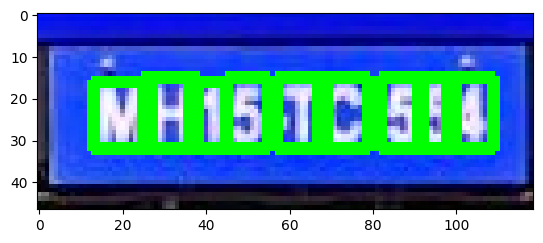

In [40]:
model = OCRModel()

file = "0000"

results = model.predict(f"{image_path}/{file}.png")
ground_truth = list(data[data['filename'] == file+".xml"]['plate'])[0]

bbs = model1(f"{image_path}/{file}.png")[0].boxes.xyxy

print(results)
print(f"Predicted licence plate: {''.join([x[0] for x in results])}", len(results))
print(f"Ground truth licence plate: {''.join(ground_truth)}", len(ground_truth))

img = cv2.imread(f"{image_path}/{file}.png")

print("# of bounding boxes: ", len(bbs))
for bb in bbs:
    xmin, ymin, xmax, ymax = bb[0:4]
    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
plt.figure()
plt.imshow(img)
plt.show()